시계열 데이터 - 베이징에서 기록한 기상정보, 미세먼지

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./datasets/PRSA_data_2010.1.1-2014.12.31.csv')
df.shape

(43824, 13)

In [3]:
df = df.set_index('No')
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


#  시계열 데이터에서 자주 사용하는 이동평균

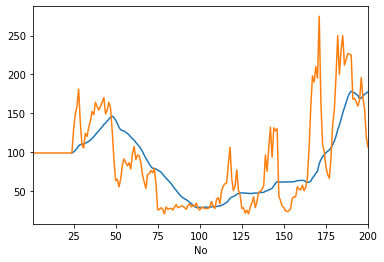

In [48]:
df['pm2.5'].rolling(window=24).mean().iloc[:200].plot()
df['pm2.5'].iloc[:200].plot()

In [4]:
# 평균값으로 누락값 채우기
df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

In [5]:
df.isna().sum().sum()

0

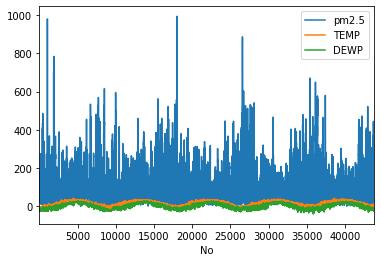

In [22]:
df[ ['pm2.5','TEMP' ,'DEWP'] ].plot()

In [25]:
df['pm2.5'].mean(), df['pm2.5'].std()
threshold = df['pm2.5'].mean() + df['pm2.5'].std()
threshold

188.4665103676712

In [26]:
df['y'] = (df['pm2.5'] > threshold).astype(np.int)

In [27]:
df['y'].mean()

0.13522270901788974

In [28]:
df.dtypes

year       int64
month      int64
day        int64
hour       int64
pm2.5    float64
DEWP       int64
TEMP     float64
PRES     float64
cbwd      object
Iws      float64
Is         int64
Ir         int64
y          int32
dtype: object

In [29]:
df_valid = df.iloc[:, 4:]

In [30]:
df_dum = pd.get_dummies(df_valid)

In [31]:
df_dum.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,y,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
No,,,,,,,,,,,,
1,98.613215,-21,-11.0,1021.0,1.79,0,0,0,0,1,0,0
2,98.613215,-21,-12.0,1020.0,4.92,0,0,0,0,1,0,0
3,98.613215,-21,-11.0,1019.0,6.71,0,0,0,0,1,0,0
4,98.613215,-21,-14.0,1019.0,9.84,0,0,0,0,1,0,0
5,98.613215,-20,-12.0,1018.0,12.97,0,0,0,0,1,0,0


In [33]:
x = df_dum.iloc[:-24]
y = df_dum.iloc[24:]['pm2.5'] # 24 시간 뒤의 미세먼지 수치
x.shape, y.shape

((43800, 12), (43800,))

In [34]:
# Linear Regression , 결정계수 1, 0은 평균값, - 평균도 안나옴
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)
model.score(x, y)

0.18603154605095806

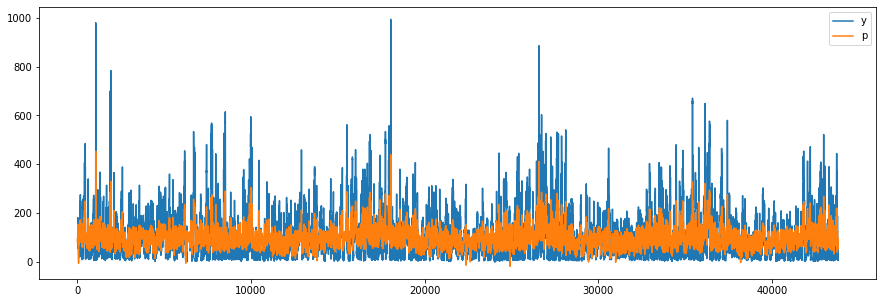

In [35]:
# 정답과 예측을 그래프로 비교해보자
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(y, label='y')
plt.plot(model.predict(x), label='p')
plt.legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000141F6438>,
      dtype=object)

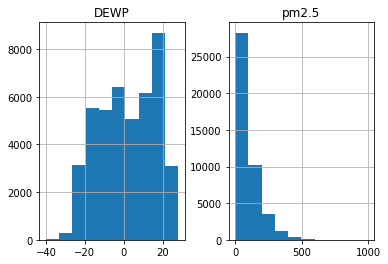

In [36]:
df[['pm2.5','DEWP']].hist()

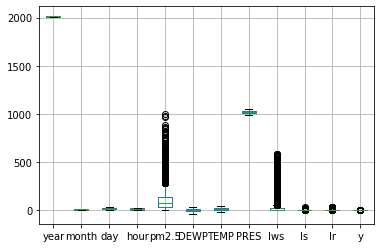

In [18]:
%matplotlib inline
df.boxplot()

이동평균으로 전처리를 하면 어떨까
1시간 데이터 > 하루의 평균 데이터 

In [56]:
df_rolling = df_dum.rolling(window=24).mean().dropna()
x = df_rolling.iloc[:-24]
y = df_rolling.iloc[24:]['pm2.5']
x.shape, y.shape

((43777, 12), (43777,))

In [57]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)
model.score(x, y) # 0.18 > 3.7  상승

0.36996248642427576

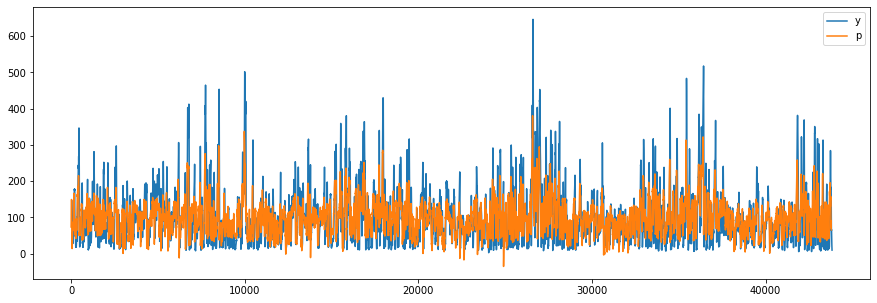

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(y, label='y')
plt.plot(model.predict(x), label='p')
plt.legend()

month 는 계절 정보를 알려주므로 X 에 포함해야 할 것 같습니다
결정계수 0.37 에서 0.4 정도로 오르길 희망하면서

In [75]:
df_month = df.drop(columns=['year', 'day', 'hour'])
df_month.head()

,month,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,y
No,,,,,,,,,,
1,1,98.613215,-21,-11.0,1021.0,NW,1.79,0,0,0
2,1,98.613215,-21,-12.0,1020.0,NW,4.92,0,0,0
3,1,98.613215,-21,-11.0,1019.0,NW,6.71,0,0,0
4,1,98.613215,-21,-14.0,1019.0,NW,9.84,0,0,0
5,1,98.613215,-20,-12.0,1018.0,NW,12.97,0,0,0


In [76]:
df_month['month'] = df_month['month'].astype(np.object)

In [79]:
df_month_dum = pd.get_dummies(df_month)

In [80]:
df_rolling = df_month_dum.rolling(window=24).mean().dropna()
x = df_rolling.iloc[:-24]
y = df_rolling.iloc[24:]['pm2.5']
x.shape, y.shape

((43777, 24), (43777,))

In [81]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)
model.score(x, y) # 0.18 > 0.37 > 0.376

0.3766582797852134

tensorflow 로 구현
- 히든 레이어를 추가하면 성능이 오를까 기대
- 최종레이어에 sigmoid 없음 
- cost 크로스 엔트로피가 아니고 MSE 
- 성능 측정시 정확도가 아니고 평균 오차 or 결정 계수
- 그래프로 예측 결과 시각화

In [115]:
import tensorflow as tf
x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32).reshape([-1, 1])
x.shape, y.shape, np.min(y), np.max(y)

((43777, 24), (43777, 1), 2.9166667, 646.3333)

In [116]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [121]:
scaler_x = MinMaxScaler().fit(x)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(x)
yn = scaler_y.transform(y)
np.min(xn), np.max(xn), np.min(yn), np.max(yn)

(0.0, 1.0000001, 0.0, 0.99999994)

In [143]:
w1 = tf.Variable(tf.random_normal(shape=[24,10]))
b1 = tf.Variable(tf.random_normal(shape=[10]))
w2 = tf.Variable(tf.random_normal(shape=[10,1]))
b2 = tf.Variable(tf.random_normal(shape=[1]))
h1 = tf.sigmoid(tf.matmul(xn, w1) + b1)
out = tf.matmul(h1, w2) + b2
cost = tf.reduce_mean((yn-out)**2)
train = tf.train.GradientDescentOptimizer(0.9).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(10000):
    _, c = sess.run([train, cost])    
    if i%1000 == 0: print(i, c, r2_score(yn, sess.run(out)))

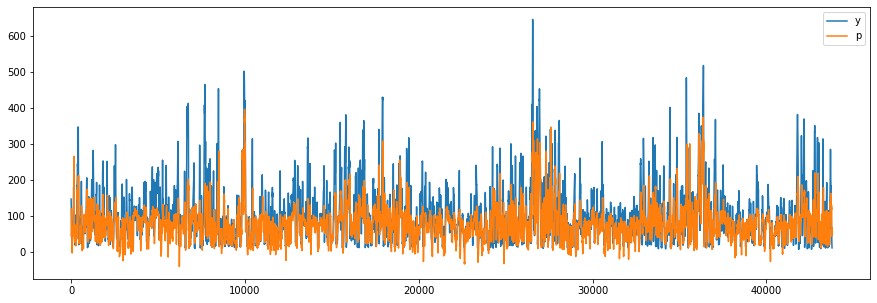

In [171]:
plt.figure(figsize=(15,5))
plt.plot(scaler_y.inverse_transform(yn), label='y')
plt.plot(scaler_y.inverse_transform(sess.run(out)), label='p')
plt.legend()

In [223]:
data = df_rolling[:1000]
T = 24
x_list = []
y_list = []
for i in range(len(data) - T * 2):
    x = data.iloc[i : i+T]
    y = data.iloc[i+T*2]['pm2.5'] #24시간 뒤 
    x_list.append(x)
    y_list.append(y)
len(x_list), len(y_list)

(952, 952)

In [224]:
X = np.stack(x_list, 0).astype(np.float32)
y = np.stack(y_list, 0).astype(np.float32).reshape([-1, 1])
type(X), X.shape, y.shape, X.dtype, y.dtype

(numpy.ndarray, (952, 24, 24), (952, 1), dtype('float32'), dtype('float32'))

In [226]:
from sklearn.preprocessing import MinMaxScaler
X_2d = X.reshape([-1, 12]) # 3d > 2d
scaler_x = MinMaxScaler().fit(X_2d)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(X_2d)
yn = scaler_y.transform(y)
xn = xn.reshape(X.shape) # 2d > 3d
xn.shape, np.min(xn), np.max(xn), np.min(yn), np.max(yn),xn.shape, yn.shape

((952, 24, 24), 0.0, 1.0, 0.0, 1.0000001, (952, 24, 24), (952, 1))

In [228]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()
#cell = tf.nn.rnn_cell.BasicRNNCell(100)
cell = tf.nn.rnn_cell.GRUCell(100) # LSTM보다 약간 빠르고 성능은 약간 떨어진다
#cell = tf.nn.rnn_cell.BasicLSTMCell(100) #장기단기텀메모리:가장 복잡하고 성능이 좋음 
outputs, last_state = tf.nn.dynamic_rnn(cell, xn, dtype=tf.float32)
#last_state = last_state[1] # LSTM 은 상태가 장기/단기 2개입니다 
h = slim.fully_connected(last_state, 1)
cost = tf.reduce_mean((yn - h)**2)
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(1000):
    _, c = sess.run([train, cost])    
    if i%100 == 0: print(i, c, r2_score(yn, sess.run(h)))
print(i, c, r2_score(yn, sess.run(h)))

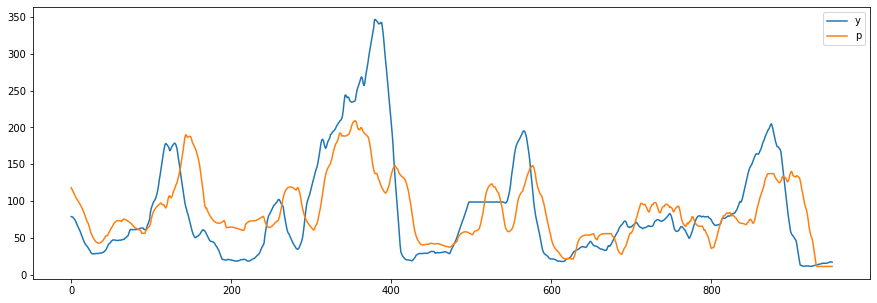

In [231]:
plt.figure(figsize=(15,5))
plt.plot(scaler_y.inverse_transform(yn), label='y')
plt.plot(scaler_y.inverse_transform(sess.run(h)), label='p')
plt.legend()